## Imports

In [1]:
import gymnasium as gym
from diffuser.utils.config import Config, get_params, get_device_settings
import os
import collections
import numpy as np
import pdb
from minari import DataCollector, StepDataCallback
import wandb
import torch
from datetime import datetime
from tqdm import tqdm

c:\Users\Beste Aydemir\AppData\Local\pypoetry\Cache\virtualenvs\adlr-uQXv-DS1-py3.10\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Diffuser Lib

In [2]:
class Args:
    def __init__(
        self,
        loader,
        savepath,
        dataset,
        horizon,
        normalizer,
        preprocess_fns,
        use_padding,
        max_path_length,
        renderer,
        model,
        dim_mults,
        device,
    ):
        self.loader = loader
        self.savepath = savepath
        self.dataset = dataset
        self.horizon = horizon
        self.normalizer = normalizer
        self.preprocess_fns = preprocess_fns
        self.use_padding = use_padding
        self.max_path_length = max_path_length
        self.renderer = renderer
        self.model = model
        # self.transition_dim=transition_dim
        # self.cond_dim=cond_dim
        self.dim_mults = dim_mults
        self.device = device


args = Args(
    loader="datasets.sequence.GoalDataset",
    savepath="saved/",
    dataset="",
    horizon=256,
    normalizer="LimitsNormalizer",
    preprocess_fns=["maze2d_set_terminals"],
    use_padding=False,
    max_path_length=280,  #from the dataset description
    renderer="utils.rendering.FrankaRenderer",
    model="models.temporal.TemporalUnet",
    dim_mults=(1, 4, 8),
    device="cpu",
)

In [3]:
dataset_config = Config(
    args.loader,
    savepath=(args.savepath, "dataset_config.pkl"),
    env="FrankaKitchen-v1",
    horizon=args.horizon,
    normalizer=args.normalizer,
    preprocess_fns=args.preprocess_fns,
    use_padding=args.use_padding,
    max_path_length=args.max_path_length,
)

_class:datasets.sequence.GoalDataset
[ utils/config ] Imported diffuser.datasets.sequence:GoalDataset

[utils/config ] Config: <class 'diffuser.datasets.sequence.GoalDataset'>
    env: FrankaKitchen-v1
    horizon: 256
    max_path_length: 280
    normalizer: LimitsNormalizer
    preprocess_fns: ['maze2d_set_terminals']
    use_padding: False

[ utils/config ] Saved config to: saved/dataset_config.pkl



In [4]:
from minari import DataCollector, list_local_datasets, load_dataset, delete_dataset
for dataset_name in list_local_datasets():
    print(dataset_name)
    #delete_dataset(dataset_name)


C:\Users\Beste Aydemir\.minari\datasets\kitchen-complete-v1\data
kitchen-complete-v1
C:\Users\Beste Aydemir\.minari\datasets\pointmaze-medium-v2\data
pointmaze-medium-v2
kitchen-complete-v1
pointmaze-medium-v2


In [5]:
dataset = dataset_config()

Name of the enviornment: FrankaKitchen-v1
Name of the enviornment: FrankaKitchen-v1
Dataset_name:kitchen-complete-v1
C:\Users\Beste Aydemir\.minari\datasets\kitchen-complete-v1\data
kitchen-complete-v1
C:\Users\Beste Aydemir\.minari\datasets\pointmaze-medium-v2\data
pointmaze-medium-v2
dataset exists!
here
{'achieved_goal': array([[-4.65501369e-04],
       [-1.66693600e-04],
       [-5.60234203e-05],
       [-1.90645442e-05],
       [-6.49669368e-06],
       [-2.21426044e-06],
       [-7.54697964e-07],
       [-2.57228215e-07],
       [-8.76726513e-08],
       [-2.98820019e-08],
       [-1.01848641e-08],
       [-3.47136907e-09],
       [-1.18316780e-09],
       [-4.03266263e-10],
       [-1.37447689e-10],
       [-4.68471302e-11],
       [-1.59671918e-11],
       [-5.44219492e-12],
       [-1.85489634e-12],
       [-6.32215579e-13],
       [-2.15481874e-13],
       [-7.34439954e-14],
       [-2.50323628e-14],
       [-8.53193220e-15],
       [-2.90799025e-15],
       [-9.91147972e-16]

## Configs for Rendering and the model

In [6]:
render_config = Config(
    args.renderer,
    savepath=(args.savepath, "render_config.pkl"),
    env="FrankaKitchen-v1",
)

_class:utils.rendering.FrankaRenderer
[ utils/config ] Imported diffuser.utils.rendering:FrankaRenderer

[utils/config ] Config: <class 'diffuser.utils.rendering.FrankaRenderer'>
    env: FrankaKitchen-v1

[ utils/config ] Saved config to: saved/render_config.pkl



In [7]:
# observation_dim = dataset.observation_dim
# action_dim = dataset.action_dim
observation_dim = 59
action_dim = 9
# -----------------------------------------------------------------------------#
# ------------------------------ model & trainer ------------------------------#
# -----------------------------------------------------------------------------#

model_config = Config(
    args.model,
    savepath=(args.savepath, "model_config.pkl"),
    horizon=args.horizon,
    transition_dim=observation_dim + action_dim,
    cond_dim=observation_dim,
    dim_mults=args.dim_mults,
    device=args.device,
)

_class:models.temporal.TemporalUnet
[ utils/config ] Imported diffuser.models.temporal:TemporalUnet

[utils/config ] Config: <class 'diffuser.models.temporal.TemporalUnet'>
    cond_dim: 59
    dim_mults: (1, 4, 8)
    horizon: 256
    transition_dim: 68

[ utils/config ] Saved config to: saved/model_config.pkl



In [8]:
renderer = render_config()

Name of the enviornment: FrankaKitchen-v1


In [9]:
model = model_config()

[ models/temporal ] Channel dimensions: [(68, 32), (32, 128), (128, 256)]
[(68, 32), (32, 128), (128, 256)]


In [10]:
diffusion_config = Config(
    _class="models.diffuser.GaussianDiffusion",
    savepath=(args.savepath, "diffusion_config.pkl"),
    horizon=256,
    observation_dim=observation_dim,
    action_dim=action_dim,
    n_timesteps=256,
    loss_type="l2",
    clip_denoised=True,
    predict_epsilon=False,
    # loss weighting
    action_weight=1,
    loss_weights=None,
    loss_discount=1,
    device=args.device,
)

_class:models.diffuser.GaussianDiffusion
[ utils/config ] Imported diffuser.models.diffuser:GaussianDiffusion

[utils/config ] Config: <class 'diffuser.models.diffuser.GaussianDiffusion'>
    action_dim: 9
    action_weight: 1
    clip_denoised: True
    horizon: 256
    loss_discount: 1
    loss_type: l2
    loss_weights: None
    n_timesteps: 256
    observation_dim: 59
    predict_epsilon: False

[ utils/config ] Saved config to: saved/diffusion_config.pkl



In [11]:
diffuser = diffusion_config(model)

## Forward pass is working

In [12]:
dataset.__len__()

0

In [13]:
dataset._data.total_episodes

AttributeError: 'GoalDataset' object has no attribute '_data'

In [14]:
from diffuser.utils.arrays import report_parameters, batchify

report_parameters(model)

print("Testing forward...", end=" ", flush=True)
batch = batchify(dataset[0])
loss, _ = diffuser.loss(*batch)
loss.backward()
print("✓")

[ utils/arrays ] Total parameters: 3.70 M
         downs.2.0.blocks.1.block.0.weight: 327.68 k | Conv1d(256, 256, kernel_size=(5,), stride=(1,), padding=(2,))
         downs.2.1.blocks.0.block.0.weight: 327.68 k | Conv1d(256, 256, kernel_size=(5,), stride=(1,), padding=(2,))
         downs.2.1.blocks.1.block.0.weight: 327.68 k | Conv1d(256, 256, kernel_size=(5,), stride=(1,), padding=(2,))
         ups.0.0.blocks.0.block.0.weight: 327.68 k | Conv1d(512, 128, kernel_size=(5,), stride=(1,), padding=(2,))
         mid_block1.blocks.0.block.0.weight: 327.68 k | Conv1d(256, 256, kernel_size=(5,), stride=(1,), padding=(2,))
         mid_block1.blocks.1.block.0.weight: 327.68 k | Conv1d(256, 256, kernel_size=(5,), stride=(1,), padding=(2,))
         mid_block2.blocks.0.block.0.weight: 327.68 k | Conv1d(256, 256, kernel_size=(5,), stride=(1,), padding=(2,))
         mid_block2.blocks.1.block.0.weight: 327.68 k | Conv1d(256, 256, kernel_size=(5,), stride=(1,), padding=(2,))
         downs.2.0.b

IndexError: index 0 is out of bounds for axis 0 with size 0

## Using the trainer requires taking care of the 'device' in the folders

In [28]:
from diffuser.utils.training import Trainer

trainer_config = Config(
    Trainer,
    savepath=(args.savepath, "trainer_config.pkl"),
    train_batch_size=32,
    train_lr=2e-4,
    gradient_accumulate_every=2,
    ema_decay=0.005,
    sample_freq=20,
    save_freq=50,
    label_freq=int(2e4 // 50),
    save_parallel=False,
    results_folder=args.savepath,
    bucket=None,
    n_reference=1,
    n_samples=1,
)


[utils/config ] Config: <class 'diffuser.utils.training.Trainer'>
    bucket: None
    ema_decay: 0.005
    gradient_accumulate_every: 2
    label_freq: 400
    n_reference: 1
    n_samples: 1
    results_folder: saved/
    sample_freq: 20
    save_freq: 50
    save_parallel: False
    train_batch_size: 32
    train_lr: 0.0002

[ utils/config ] Saved config to: saved/trainer_config.pkl



In [30]:
trainer = trainer_config(diffuser, dataset, renderer, device = "cpu", name="franka")

use_wandb = False

current_time = datetime.now().strftime("%d_%m_%Y-%H-%M")

if use_wandb:
    run = wandb.init(
        config=trainer_config.to_dict(),
        project="Experiment-1",
        name=f"Name-1_{current_time}",
        group="Group-Name",
        job_type="training",
        reinit=True,
    )

ValueError: num_samples should be a positive integer value, but got num_samples=0

# Training process inlcluding rendering

In [17]:
import torch

torch.cuda.is_available()

False

Epoch 0 / 2 | saved/
[ utils/training ] Saved model to saved/state_0.pt
0:   0.2127 | a0_loss:   0.6304 | t:   4.3036
(1, 256, 4)
1
The last observation [-1.9455035  2.5265174 -3.2520628  0.0878849]


AttributeError: 'Maze2dRenderer' object has no attribute 'starting'

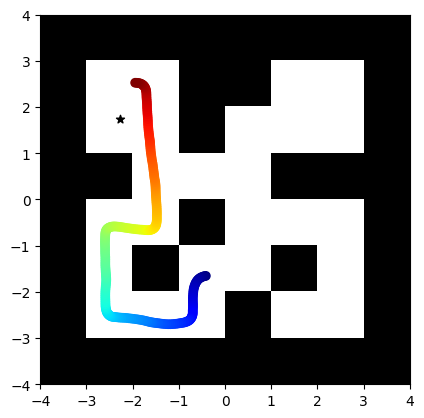

In [25]:
# n_epochs = int(args.n_train_steps // args.n_steps_per_epoch)


n_epochs = 2
for i in range(n_epochs):
    #wandb.log({"Epoch": i})
    print(f"Epoch {i} / {n_epochs} | {args.savepath}")
    trainer.train(n_train_steps=1000)
#wandb.finish()

## Random Test (don't run)

In [ ]:
from minari import DataCollector, list_local_datasets, load_dataset, delete_dataset
for dataset_name in list_local_datasets():
    print(dataset_name)
    delete_dataset(dataset_name)

In [ ]:
import minari
ddss = minari.download_dataset("pointmaze-medium-v2")

In [ ]:
data = load_dataset("pointmaze-medium-v2")

In [ ]:
data._data.total_episodes

In [ ]:

data[0].observations["observation"]

In [20]:
env = gym.make(
        "PointMaze_Medium-v3", continuing_task=True)

In [25]:
env.reset()

({'observation': array([0.59587286, 1.58655485, 0.        , 0.        ]),
  'achieved_goal': array([0.59587286, 1.58655485]),
  'desired_goal': array([-2.37061747, -0.27548277])},
 {'success': False})

In [26]:
env.unwrapped.point_env.init_qpos[:2] 

array([0.59587286, 1.58655485])

In [ ]:
print(len(dataset))
for i in range(40):
    print(dataset[i].observations["observation"])


In [ ]:
reshaped = {}
for key, val in dataset.items():
    dim = val.shape[-1]
    reshaped[key] = val.reshape(-1, dim)

In [ ]:
def process_maze2d_episode(episode):
    '''
        adds in `next_observations` field to episode
    '''
    #assert 'next_observations' not in episode
    ep = {}
    length = len(episode.observations)
    next_observations = episode.observations["observation"][1:].copy()
    for key, val in episode.observations.items():
        ep[key] = val[:-1]
    ep['next_observations'] = next_observations
    for attr, value in vars(episode).items():
      if attr == "observations":
        continue
      elif attr == "terminations":
        ep["terminals"] = value
      elif attr == "truncations":
        ep["timeouts"] = value
      elif attr == "id" or attr == "seed" or attr == "total_timesteps" or "infos"
        continue
      else:
        ep[attr] = value

    return ep

In [ ]:
a = process_maze2d_episode(dataset[0])

In [ ]:
print(a.keys())

In [ ]:
a["terminals"].any()

In [ ]:
dataset[0].infos["goal"].shape

In [ ]:
for attr, value in vars(dataset[0]).items():
    if attr == "observations":
        continue
    print(f"{attr}: {value}")

In [ ]:
# dataset = get_dataset()
# dataset = preprocess_fn(dataset)

# N = dataset['rewards'].shape[0]
N = dataset[0].rewards.shape[0]
# N = dataset._data.total_episodes
data_ = collections.defaultdict(list)

# The newer version of the dataset adds an explicit
# timeouts field. Keep old method for backwards compatability.
use_timeouts = False
print(N)
episode_step = 0
for i in range(N):
    # print(dataset[i])
    # dataset[i].observations
    # done_bool = bool(dataset['terminals'][i])
    done_bool = bool(dataset[episode_step].terminations[i])

    final_timestep = episode_step == env._max_episode_steps - 1

    # for k in dataset:
    for attr, value in vars(dataset[episode_step]).items():
        # if 'metadata' in k: continue
        # data_[k].append(dataset[k][i])
        data_[attr].append(value)

    if done_bool or final_timestep:
        episode_step = 0
        episode_data = {}
        for k in data_:
            episode_data[k] = np.array(data_[k])
        episode_data = process_maze2d_episode(dataset[i])
        print(episode_data)
        data_ = collections.defaultdict(list)

        episode_step += 1
    break